This notebook has been designed to strengthen one's understanding of how one numerically constructs a stellar structure by simply using a polytropic equation of state with the appropriate index. 

The cell below sets up the all the functions required that will act as the backbone for this notebook. If you are less computationally inclined, you can simply skip down to the next cell straight into the theoretical introduction

In [62]:
# This block will simply check for any missing python modules and will quietly install them within the Jupyter container.
# No packages will be installed within your actual python directory, so if you have any packages setup in a given way,
# they will not be overwritten
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib','ipython','tabulate'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

#The necessary libraries are imported here
import tabulate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math

%matplotlib inline 

def runkutt(y,t,dt,n):
#Runge-Kutta 4th Order integrater as described in 
#An Introduction to Computational Physics, 2nd Edition by Tao Pang    
    c1 = np.zeros(2)
    c2 = np.zeros(2)
    c3 = np.zeros(2)
    c4 = np.zeros(2)
  
    c1 = g(y,t,n)
    
    c2 = y + dt*c1/2
    c2 = g(c2,t+dt/2,n)
    
    c3 = y + dt*c2/2
    c3 = g(c3,t+dt/2,n)
    
    c4 = y + dt*c3/2 
    c4 = g(c4,t+dt/2,n)
    
    return y + dt*(c1 + 2*(c2+c3) +c4)/6

def g(y,t,n):
#generates the vectors that act as the two 1st order differential equations
    v = np.zeros(2)
    
    v[0] = -y[1]/t**2
    v[1] = (y[0]**n)*t**2
    
    return v
def lane_emden_solver(n):
#only takes the polytropic index as input and returns the axis and polytrope
    dt = 20/1000 # the maximum is chosen at 20 to show the roots between n =4 and 5
    y1 = np.zeros(1000)
    y2 = np.zeros(1000)
    y  = np.zeros(2)
    y[0] = 1
    y[1] = 0
    
    y1[0] = y[0]
    y2[0] = y[1]
    t = np.zeros(1000)
    for i in range (1000):
        t[i]  = dt*(i+1)
        y     = runkutt(y,t[i],dt,n)
        y1[i] = y[0]
        y2[i] = y[1]
    return t,y1

def newton_raphson(x,y,dy,x0,i,n):
#Since we don't have an explicit function, we need to interpolate the arrays at every new "root" 
#until the method converges
    if n>=5:
    # since polytropic indices of 5 and beyond admit no roots, we force the output to infinity to
    # avoid any garbage output
        x0 = np.infty
        return x0
    h = y[i]/dy[i]
    while abs(h)>=1e-10:
        x0-=h
        y0 = np.interp(x0,x,y)
        dy0 = np.interp(x0,x,dy)
        h = y0/dy0
    
    return x0
def poly_prop(n,cut_off):
    """this is the main function. It is simply fed the polytropic index and a boolean. The polytropic index
    will determine the polytrope while the cutt_off indicates whether or not you want the solution over the whole axis
    or just up till the root. The method will return all 
    """
    xi,theta = lane_emden_solver(n) #solving the Lane-Emdend differential equation 
                                    #via Runge-Kutta 4th Order
   
    for i in range(len(theta)): #look for the guess for the root solver, which is at the 
                                #index before the 1st negative
        if theta[i]<0:
            break
    d_theta = np.gradient(theta,xi)
    xi_1 = newton_raphson(xi,theta,d_theta,xi[i-1],i,n) #solving for the root 
    
    d_theta_xi_1 = np.interp(xi_1,xi,d_theta) #solving for the derivative at the root
    root_diff_prod = np.power(xi_1,2)*d_theta_xi_1 #xi^2*dtheta/dxi @ xi_1
    if cut_off == True: #the cutoff is used to simulate the star since the values beyong the root
                        # are not required
        xi = xi[0:i-1]
        theta = theta[0:i-1]
        d_theta = d_theta[0:i-1]
    
    return xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod

#physical constants
m_sun = 1.989e+33 #grams
r_sun = 6.957e+10 #cm
G = 6.67408e-8    #dyne.(cm/g)^2
#some plot parameters
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18

In simple terms, the polytropic equation of state is a power-law relation between the pressure (P) and the density $(\rho)$. Algebraically, the relation can be written down as $$P = K\rho^{1+1/n}$$ where n is the polytropic index. The above equation of state is substituted in the equation of hydrostatic equilibrium $$\frac{dP}{dr}=-\frac{GM}{r^{2}}\rho$$ to arrive at the Lane-Emden equation $$\frac{1}{\xi^2}\frac{d}{d\xi}\left(\xi^2\frac{d\theta_n}{d\xi}\right) = -\theta_n^n$$ Full derivation of the Lane-Emden equation is provided [here](https://github.com/jaadt7/Lane_Emden/blob/master/lane_emden_derivation.pdf). The $\theta_n(\xi)$ is known as the Lane-Emden solution of index n, or polytrope of index n. The differential equation has a mixed boundary condition at the center where $$\theta_{n}(0)=1 ; \frac{d\theta_{n}}{d\xi}\Bigr|_{\xi=0}=0$$. Their physical significance reflects the existance of central densities and pressures, and no exchange to a "negative" radius.

Another property of polytropes is that they admit roots for indices between 0 and 5; with 5 exclusive. Since $\xi$ is defined as the dimensionless radius, the axis of the polytrope should only extend to the root since it would be the surface of the star.


To numerically solve the Lane-Emden equation, we split it into 2 first order differential equations:$$\frac{d\theta}{d\xi} = -\frac{\phi}{\xi^2}$$ $$\frac{d\phi}{d\xi}=\theta^n\xi^2$$ and feed it into the solver with the aforementioned boundary conditions. The cell below will do exactly that, outputting a graph over the whole axis, and tabulating certain properties, their importance will be emphasized in subsequent cells

<ipython-input-62-4cb232ddf3a3>:46: RuntimeWarning: overflow encountered in double_scalars
  v[1] = (y[0]**n)*t**2
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1081: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1081: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/jaadt7/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1097: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


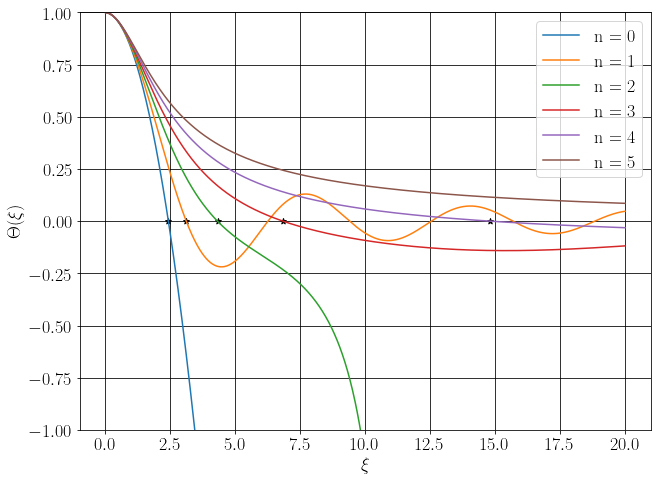

<IPython.core.display.Math object>

0,2.43612,0.816497
1,3.12329,0.31996
2,4.32581,0.128195
3,6.84772,0.0428836
4,14.8213,0.00816061
5,inf,0.00426936


In [63]:
plt.figure(figsize=(10.24,7.68))
cut_off = False #just to show the full form of the polytropes
table = np.empty((6,3))
for n in range(0,6):
    xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)
    table[n] = [n,xi_1,-d_theta_xi_1]
    plt.plot(xi,theta,label = 'n = '+str(n))
    plt.scatter(xi_1,0,marker = '*',color = 'black')
    
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\Theta(\xi)$')
plt.ylim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18
plt.grid(color = 'black')
plt.legend()
plt.show()
display(Math(r'n  \;\;\;\;\;  \xi_{1}   \;\;\;\;\; -\xi_{1}^{2}\frac{d\theta}{d\xi}\Bigr|_{\xi=\xi_{1}}'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Another aspect of the Lane-Emden equation is that it admits 3 analytical solutions at indices 0,1, and 5. The solutions and their roots are: $$\theta_0(\xi) = 1 - \frac{\xi^2}{6}; \xi_1 = \sqrt6$$ $$\theta_1(\xi) = \frac{sin(\xi)}{\xi}; \xi_1 = \pi$$ $$\theta_5(\xi) = \frac{1}{\sqrt{ \left( 1+\frac{\xi^2}{3} \right)} }; \xi_1 \rightarrow \infty$$
A detailed derivation can be found [here](https://github.com/jaadt7/Lane_Emden/blob/master/analytic_solutions_lane_emden.pdf). 

Now that we've studied the Lane-Emden equation, let's put it to use in a physical problem.

Let's say we wish to determine how well a polytrope of index 3 can describe a main sequence star given total mass and radius. From there we can determine central pressure, density, the constant of proportionality K and the scale length ($r_{n}$). The formulas listed are derived and discussed in this [book](https://link.springer.com/book/10.1007/978-1-4419-9110-2)
: $$P_c = \frac{8.952e+14}{(n+1)(\theta'_{n})^2_{\xi_1}}\left(\frac{M}{M_\odot}\right)^2\left(\frac{R}{R_\odot}\right)^{-4}dyne.cm^{-2}$$ $$K = \frac{G}{n+1}M^{1-1/n}R^{-1+3/n}\left(\frac{4\pi}{\xi_1^{n+1}(-\theta'_n\Bigr|_{\xi_1})^{n-1}}\right)^{1/n}$$ $$\rho_c = \left(\frac{P_c}{K}\right)^{\frac{n}{n+1}} g/cc$$ $$r_n = \sqrt{\frac{(n+1)P_c}{4\pi G\rho_c^2}}$$

Now that the central terms and length scale are calculated, we can use the dimensionless definitions used to derive the Lane-Emden equation to determine the density and pressure profiles $$P = P_{c} \theta_{n}^{n+1}$$ $$ \rho = \rho_{c}\theta_{n}^{n}$$ To get the mass profile in terms of the polytrope, we separate variables in the mass continuity equation and substitute the polytropic properties where applicable $$\frac{dM}{dr} = 4\pi r^{2}\rho$$ $$dM = 4\pi r^{2} \rho dr$$ $$M(r) = 4\pi \int_{0}^{R} r^{2}\rho dr$$ $$M(\xi) = 4\pi r_n^3 \rho_c (-\xi^2\theta'_n\Bigr|_\xi)$$

Now that everything pertaining to the exercise is well and properly defined, let's put it to the test. The below cell will handle the computational side of things and output the graphs for the mass, pressure, and density profiles as a function of radius

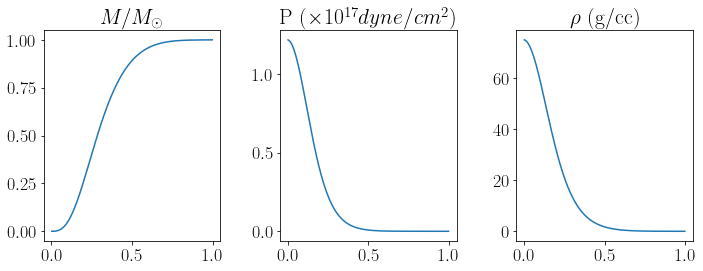

In [64]:
n = 3 #polytropic index
M = 1.0 #total mass in solar masses
R = 1.0#total radius in terms of solar radius
cut_off = True # since we're building a physical model, 
               #we have to cut the arrays down till the (1st) root of the polytrope

#Calculating the polytope and it's properties
xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)

#calculating K
term1 = G/(n+1)
term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
term3 = 4*np.pi
term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
K = term1*term2*np.power(term3/term4,1/n)

#Calculating the central pressure and pressure profile
term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
term2 = (n+1)*np.power(d_theta_xi_1,2)
P_c   = term1/term2 #dyne/cm^2
P = P_c*np.power(theta,n+1)
#Calculating central density and density profile
rho_c = np.power(P_c/K,n/(n+1))
rho = rho_c*np.power(theta,n)
#length scale and radius
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)
r = r_n*xi
#calculating the mass profile
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta)
#graphing the output. Everything is graphed as a function of R/R_{sun}
#graphing    
fig,axes= plt.subplots(1,3,figsize = (10,4))

axes[0].plot(r/r_sun,m/m_sun)
axes[1].plot(r/r_sun,P)
axes[2].plot(r/r_sun,rho)

fig.tight_layout()
offset = axes[0].yaxis.get_major_formatter().get_offset()
axes[0].set_title(r'$M/M_{\odot}$'+offset)
axes[0].yaxis.offsetText.set_visible(False)

offset = axes[1].yaxis.get_major_formatter().get_offset()
axes[1].set_title('P ('+offset+r'$dyne/cm^{2})$')
axes[1].yaxis.offsetText.set_visible(False)

offset = axes[2].yaxis.get_major_formatter().get_offset()
axes[2].set_title(r'$\rho$'+ ' ('+offset+'g/cc)')
axes[2].yaxis.offsetText.set_visible(False)


Now let's try another exercise. We shall determine the properties of a white dwarf of central density $\rho_c = 10^{11} g/cc$, polytropic index 3/2, and K ~ $10^{14}$. Via the formulae from the mentioned book, we can calculate the total mass and radius of the white dwarf from the properties of the polytrope. The radius: $$R = r_n\xi_1$$ Total mass: $$M = -4\pi r_n^3 \rho_c \xi_1^2 \theta'_n\Bigr|_{\xi_1}$$ Central pressure: $$P_c = K\rho_c^{1+1/n}$$

<ipython-input-62-4cb232ddf3a3>:46: RuntimeWarning: invalid value encountered in double_scalars
  v[1] = (y[0]**n)*t**2


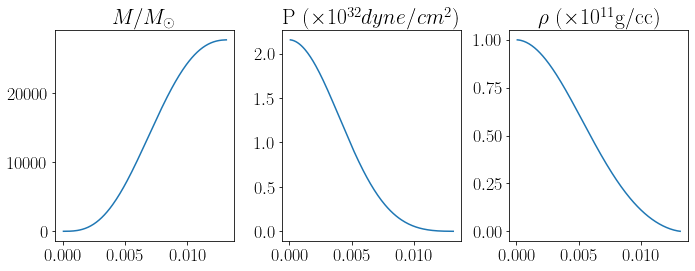

In [65]:
n = 3/2
K = 1e+14
rho_c = 1e+11
#Calculating the polytope and it's properties
xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)
#Calculating central pressure and profile
P_c = K*np.power(rho_c,1+1/n)
P = P_c*np.power(theta,n+1)
#density profile
rho = rho_c*np.power(theta,n)
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)
#mass and radius
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta)
r  = r_n*xi
#graphing    
fig,axes= plt.subplots(1,3,figsize = (10,4))

axes[0].plot(r/r_sun,m/m_sun)
axes[1].plot(r/r_sun,P)
axes[2].plot(r/r_sun,rho)

fig.tight_layout()
offset = axes[0].yaxis.get_major_formatter().get_offset()
axes[0].set_title(r'$M/M_{\odot}$'+offset)
axes[0].yaxis.offsetText.set_visible(False)

offset = axes[1].yaxis.get_major_formatter().get_offset()
axes[1].set_title('P ('+offset+r'$dyne/cm^{2})$')
axes[1].yaxis.offsetText.set_visible(False)

offset = axes[2].yaxis.get_major_formatter().get_offset()
axes[2].set_title(r'$\rho$'+ ' ('+offset+'g/cc)')
axes[2].yaxis.offsetText.set_visible(False)
#a warning will appear when using fractional indices. This is because the algorithm is trying to take a root of a negative number.
#the algorithm will cut off at the point of inflection

Looking at the mass graph, it's obvious we've exceeded the Chandrasekhar limit by a few orders of magnitude. (modeling a black whole structure maybe? seems far fetched). You could go back to the block and see which value of n would give an appropriate distribution (hint: it's an integer less than 5)

It is apparent that to set up the profiles of a polytrope, you would need either $\rho_c$, K, and n or M,R, and n. Should you wish to set up your own polytrope and see how the profiles behave, the bottom cell will allow you to do exactly that 

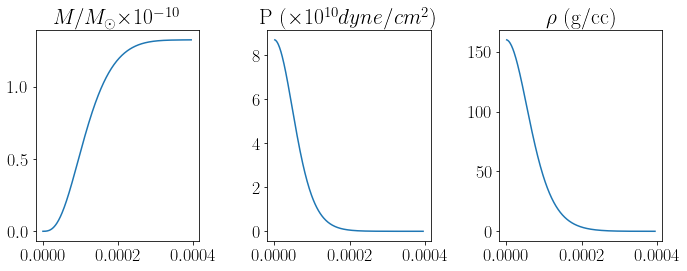

In [66]:
n_K_rho_c = True  #set the marker to true in case you want to supply n, K and rho_c
                  #else set M,R and n. No matter the choice, set the rest to zero
                  #even if you don't, the code will overwrite any variables 

n     = 3      
K     = 1e+8     
M     = 1.0 #in solar masses
R     = 1.0 #in solar radius
rho_c = 160.0 #in g/cc

if n_K_rho_c:
    xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)
    #Calculating central pressure
    P_c = K*np.power(rho_c,1+1/n)
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)

    P = P_c*np.power(theta,n+1)
    rho = rho_c*np.power(theta,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta)
    r  = r_n*xi
else:
    xi,xi_1,theta,d_theta,d_theta_xi_1,root_diff_prod = poly_prop(n, cut_off)
    #calculating K
    term1 = G/(n+1)
    term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
    term3 = 4*np.pi
    term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
    K = term1*term2*np.power(term3/term4,1/n)

    #Calculating the central pressure
    term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
    term2 = (n+1)*np.power(d_theta_xi_1,2)
    P_c   = term1/term2 #dyne/cm^2
    #Calculating central density
    rho_c = np.power(P_c/K,n/(n+1))
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)

    P = P_c*np.power(theta,n+1)
    rho = rho_c*np.power(theta,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta)
    r  = r_n*xi

#graphing    
fig,axes= plt.subplots(1,3,figsize = (10,4))

axes[0].plot(r/r_sun,m/m_sun)
axes[1].plot(r/r_sun,P)
axes[2].plot(r/r_sun,rho)

fig.tight_layout()
offset = axes[0].yaxis.get_major_formatter().get_offset()
axes[0].set_title(r'$M/M_{\odot}$'+offset)
axes[0].yaxis.offsetText.set_visible(False)

offset = axes[1].yaxis.get_major_formatter().get_offset()
axes[1].set_title('P ('+offset+r'$dyne/cm^{2})$')
axes[1].yaxis.offsetText.set_visible(False)

offset = axes[2].yaxis.get_major_formatter().get_offset()
axes[2].set_title(r'$\rho$'+ ' ('+offset+'g/cc)')
axes[2].yaxis.offsetText.set_visible(False)


In [67]:
#saving to file. uncomment the lines to save to file
#data = np.column_stack((r,m,P,rho))
#np.savetxt('data.txt',data)